In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow as tf
import random
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D,MaxPooling2D,Dropout,InputLayer
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.applications import VGG19
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib.colors import LinearSegmentedColormap
import os
import cv2
import math
from imblearn.over_sampling import RandomOverSampler

In [20]:
directory='./Belgium_Datasets'
train_dir=directory+'/BelgiumTSC_Training/Training'
test_dir=directory+'/BelgiumTSC_Testing/Testing'
trainclasses=os.listdir(train_dir)
testclasses=os.listdir(test_dir)

In [21]:
print(trainclasses)

['00000', '00001', '00002', '00003', '00004', '00005', '00006', '00007', '00008', '00009', '00010', '00011', '00012', '00013', '00014', '00015', '00016', '00017', '00018', '00019', '00020', '00021', '00022', '00023', '00024', '00025', '00026', '00027', '00028', '00029', '00030', '00031', '00032', '00033', '00034', '00035', '00036', '00037', '00038', '00039', '00040', '00041', '00042', '00043', '00044', '00045', '00046', '00047', '00048', '00049', '00050', '00051', '00052', '00053', '00054', '00055', '00056', '00057', '00058', '00059', '00060', '00061']


In [22]:
df=[[]]
df=pd.DataFrame(df)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Training/Training/"+i+'/'+df1["Filename"]
    df=pd.concat([df,df1],ignore_index=True)

df['Rotate']=0
df["length"] = df["Roi.X2"]-df["Roi.X1"]
df["height"] = df["Roi.Y2"]-df["Roi.Y1"]
df=df.dropna()
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0.0,0,116.0,118.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0.0,0,99.0,103.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0.0,0,87.0,89.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0.0,0,78.0,86.0
5,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0.0,0,106.0,115.0


In [23]:
df.describe()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
count,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.000000,4591.0,4591.000000,4591.000000
mean,124.844261,109.740362,10.558048,9.348508,113.778697,99.883032,34.005228,0.0,103.220649,90.534524
std,73.056649,60.209324,5.982332,4.860009,67.072788,55.385101,16.067205,0.0,61.111287,50.557826
min,22.000000,20.000000,5.000000,5.000000,16.000000,14.000000,0.000000,0.0,11.000000,9.000000
25%,79.000000,69.000000,7.000000,6.000000,71.000000,63.000000,22.000000,0.0,64.000000,57.000000
50%,107.000000,96.000000,9.000000,8.000000,97.000000,88.000000,37.000000,0.0,88.000000,80.000000
75%,151.000000,133.500000,13.000000,11.000000,137.000000,122.000000,46.000000,0.0,124.000000,111.000000
max,724.000000,529.000000,60.000000,44.000000,664.000000,484.000000,61.000000,0.0,604.000000,440.000000


In [24]:
num_of_classes = df["ClassId"].nunique()
resize_x  = 32
resize_y  = 32
num_of_channels = 3
directory = ""
Epochs=50
train_length = len(df)
Y_col_name="ClassId"

In [25]:
# Necessary Functions
def remove_outlier(df,parameter):
    Percentile25 = df[parameter].quantile(0.25)
    Percentile75 = df[parameter].quantile(0.75)
    iqr = Percentile75 - Percentile25
    lowerlimit = Percentile25 - 1.5*iqr
    upperlimit = Percentile75 + 1.5*iqr
    temp1 = df[parameter]>lowerlimit
    temp2 = df[parameter]<upperlimit
    return df[temp1 & temp2] 

def get_max_index(arr):
    length = len(arr)
    mini = 0
    value = 0
    for i,val in enumerate(arr):
        if mini < val :
            mini = val
            value = i
    return value

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = []
    for x in range(num_of_classes):
        y_labels.append(values[x])
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def Predict_for_single_example(model,img):
    img  = np.array(img)
    img  = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    img = tf.expand_dims(img, axis=0)
    probability = model.predict(img)
    value = get_max_index(probability[0])
    return value
    
def Predict_for_Multiple_examples(model,images):
    img = []
    for j in range(len(images)):
        img.append(np.array(images[j]))
    img = np.array(img)
    img = tf.convert_to_tensor(img,dtype=float)
    img = img/255.0
    probability = model.predict(img)
    values = []
    for val in probability:
        values.append(get_max_index(val))
    return values

def PredictTest(model,df,start,length):
    images = []
    y_test = []
    length = min(length,len(df)-start)
    for i in range(length):
        row = df.loc[start+i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
    

    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

def PredictTest(model,df):
    images = []
    y_test = []
    length = len(df)
    for i in range(length):
        row = df.loc[i].values
        images.append(Image.open(directory+row[7]).crop((row[2],row[3],row[4],row[5])).resize((resize_x,resize_y)))
        y_test.append(row[6])
        
    y_predicted = Predict_for_Multiple_examples(model,images)

    return y_test,y_predicted

Total Training Examples :  4591


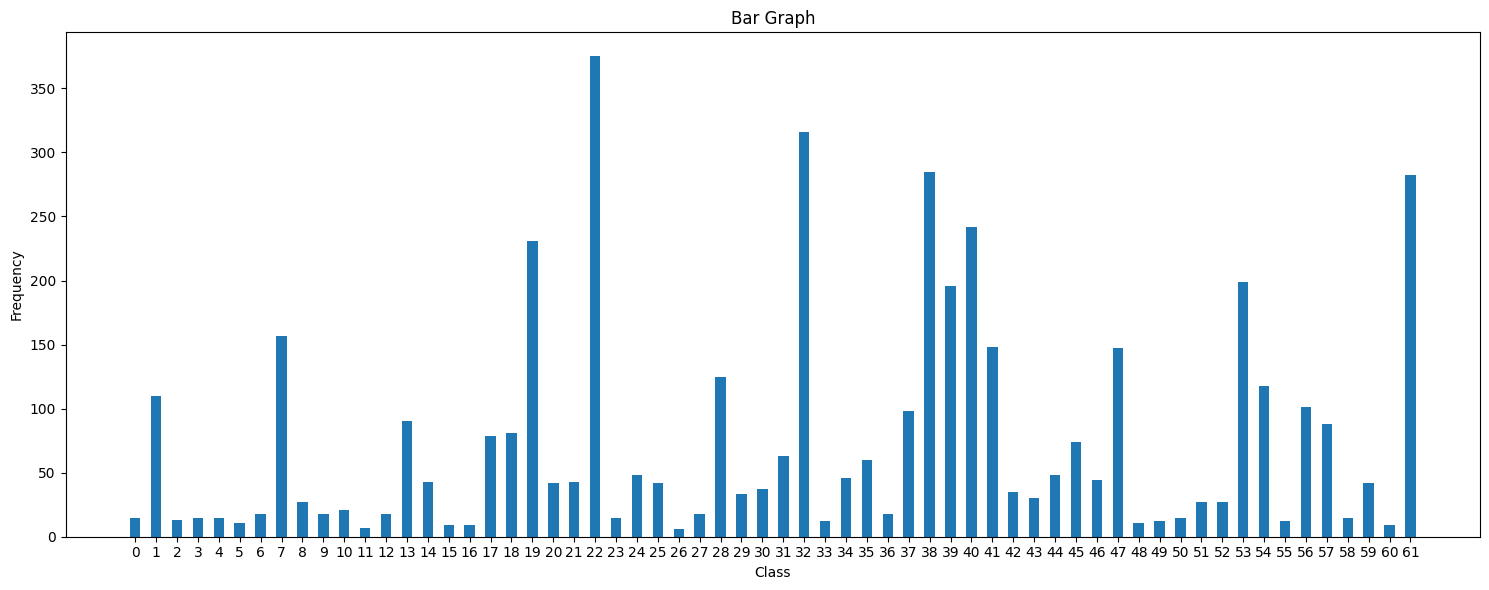

In [26]:
#Statistics of Data
viewStatistics(df)

In [27]:
train_length = len(df)
print("Total Training Examples : ",len(df))

Total Training Examples :  4591


Total Training Examples :  23250


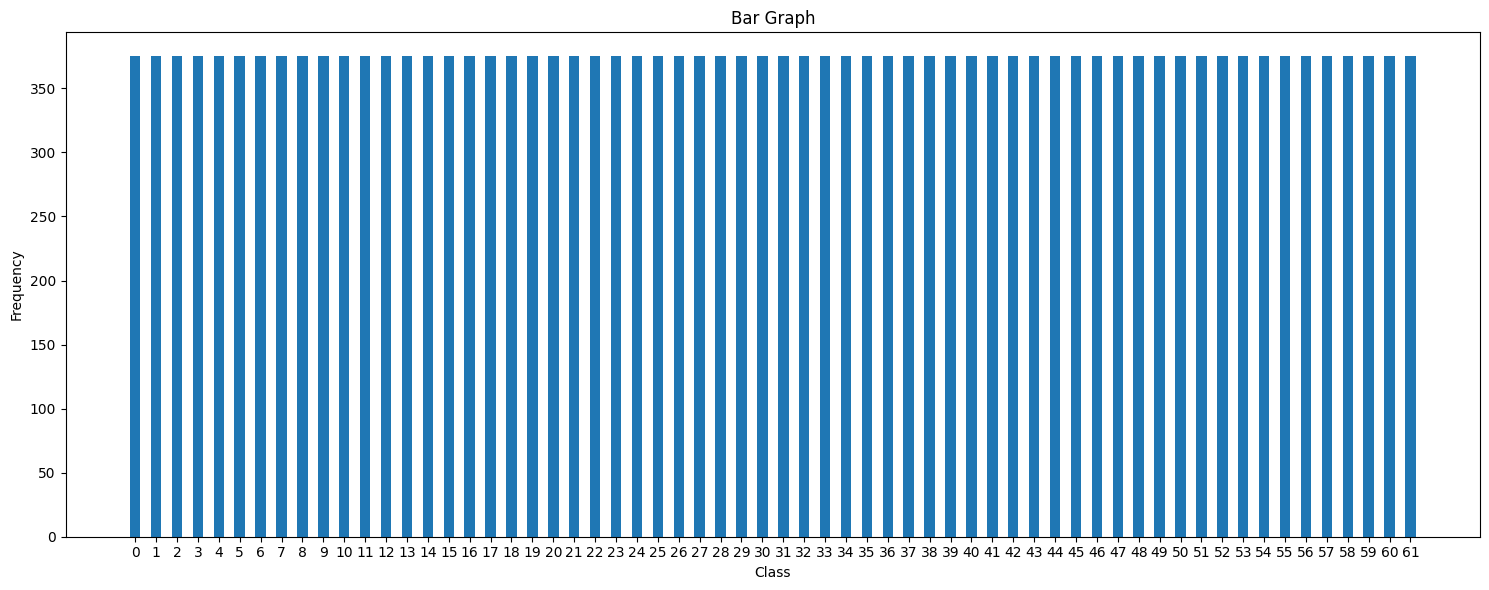

In [28]:
X = df.drop(Y_col_name, axis=1)
y = df[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df = pd.DataFrame(X_resampled, columns=X.columns)
df[Y_col_name] = y_resampled
df[Y_col_name].astype(str)

viewStatistics(df)

In [29]:
df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,Rotate,length,height,ClassId
0,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,141.0,142.0,12.0,12.0,128.0,130.0,0,116.0,118.0,0.0
1,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,120.0,123.0,10.0,10.0,109.0,113.0,0,99.0,103.0,0.0
2,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,105.0,107.0,9.0,9.0,96.0,98.0,0,87.0,89.0,0.0
3,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,94.0,105.0,8.0,9.0,86.0,95.0,0,78.0,86.0,0.0
4,./Belgium_Datasets/BelgiumTSC_Training/Trainin...,128.0,139.0,11.0,12.0,117.0,127.0,0,106.0,115.0,0.0


In [30]:
# Sample Images and there crop according to data given in csv
def showExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title(directory+val[0])
        print(directory+val[0])
    ax.axis('off')

def showTestExamples(df):
    num_rows = 5
    num_cols = 2
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 20))
    total_images = []
    for i in range(5):
        integer = random.randint(0,len(df))
        total_images.append(df.iloc[integer].values)
    total_images = list(total_images)
    for i,val in enumerate(total_images):
        row = i
        col=0
        ax = axes[row, col]
        img = Image.open(directory+val[0])
        ax.imshow(img)
        img = img.crop((val[3],val[4],val[5],val[6]))
        ax = axes[row,col+1]
        ax.imshow(img)
        ax.set_title("Class : "+str(val[7]))
    ax.axis('off')
    

./Belgium_Datasets/BelgiumTSC_Training/Training/00040/00460_00002.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00033/00340_00001.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00006/00221_00002.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00058/00107_00000.ppm
./Belgium_Datasets/BelgiumTSC_Training/Training/00029/00650_00000.ppm


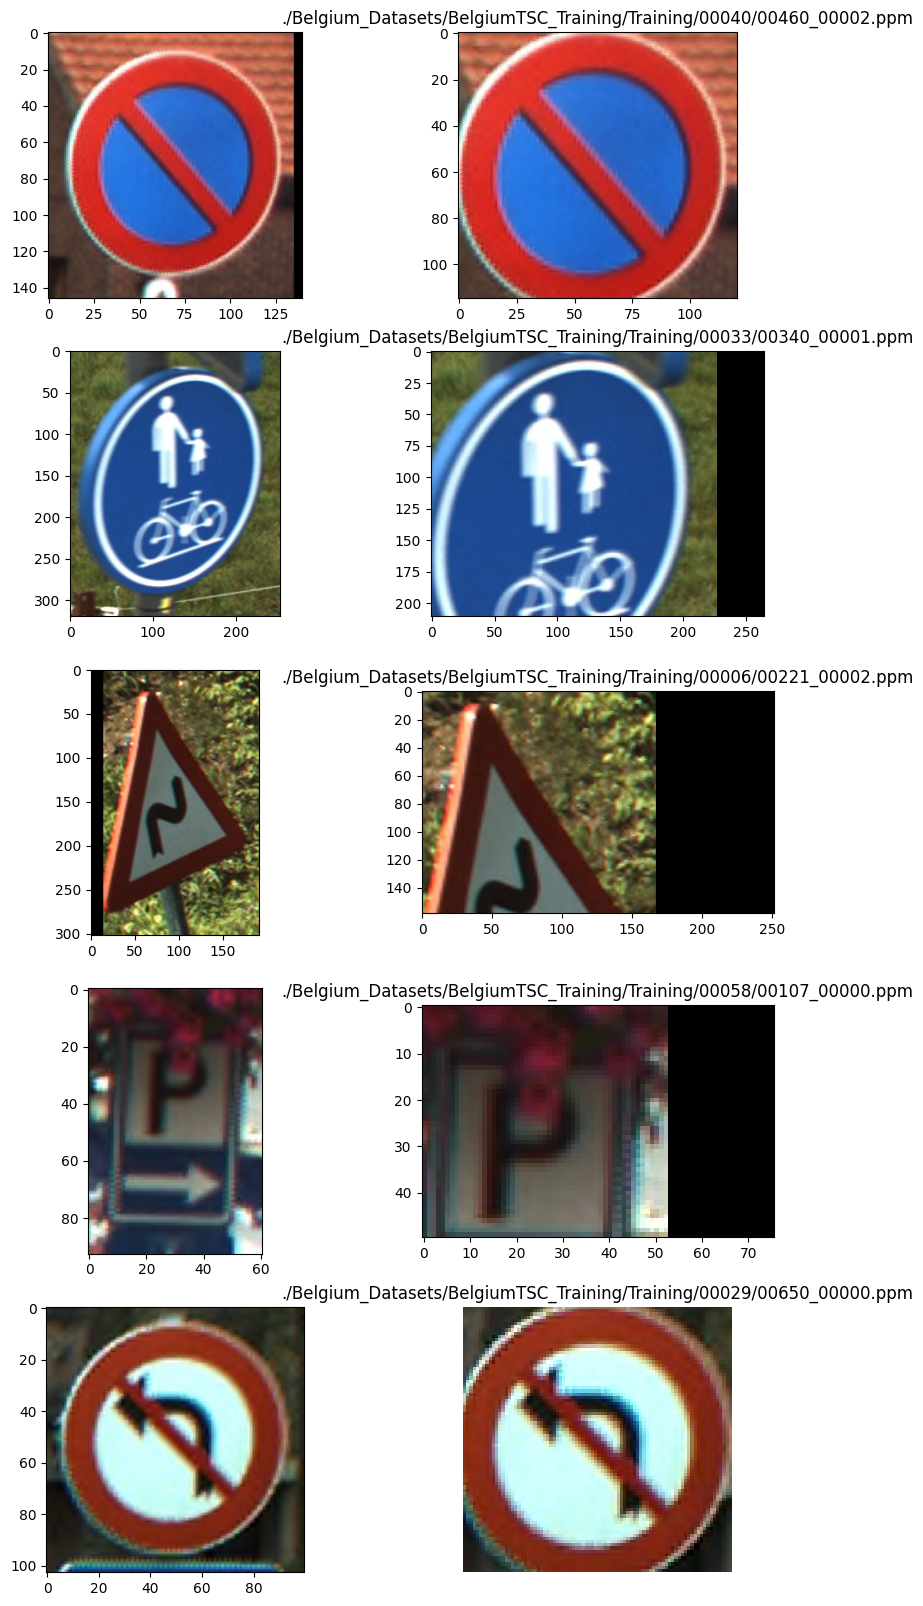

In [31]:
showExamples(df)

In [44]:
def preprocess(image, target_height=resize_x, target_width=resize_y):
        original_height, original_width= image.size
        height_ratio = target_height / original_height
        width_ratio = target_width / original_width
        resize_ratio = min(height_ratio, width_ratio)
        new_height = int(original_height * resize_ratio)
        new_width = int(original_width * resize_ratio)
        image  = np.array(image)
        resized_image = cv2.resize(image, (new_width, new_height))
        pad_height = max(0, (target_height - new_height) // 2)
        pad_width = max(0, (target_width - new_width) // 2)
        centered_image = cv2.copyMakeBorder(resized_image, pad_height, target_height - new_height - pad_height,pad_width, target_width - new_width - pad_width,cv2.BORDER_CONSTANT, value=(255, 255, 255))
        return centered_image

def mixing(images, labels):
    images = np.array(images)
    labels = np.array(labels)
    s = np.arange(images.shape[0])        
    np.random.seed(43)
    np.random.shuffle(s)
    images=images[s]
    labels=labels[s]
    return images, labels

def load_train(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        filename = row["Filename"]
        image = Image.open(directory+filename)
        images.append(preprocess(image))
        labels.append(row["ClassId"])
        image.close()
    return mixing(images, labels)

def viewStatistics(df):
    #Statistics of Data
    print("Total Training Examples : ",len(df))
    values = df["ClassId"].value_counts()
    x_labels = [str(x) for x in range(num_of_classes)]
    y_labels = [0 for i in range(num_of_classes)]
    for x in values.keys():
        y_labels[int(x)]+=values[x]
    plt.figure(figsize=(15, 6))
    plt.bar(x_labels,y_labels,width=0.5)
    plt.title('Bar Graph')
    plt.xlabel('Class')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

def load_test(df):
    images = []
    labels = []
    for index, row in df.iterrows():
        filename = row["Filename"]
        image = Image.open(directory+filename)
        images.append(preprocess(image))
        labels.append(row["ClassId"])
        image.close()
    return mixing(images, labels)

In [45]:
start = time.time()

train_images, train_labels = load_train(df)
shape = train_images[0].shape
print(shape)

train_images = train_images.astype('float32') / 255.

train_labels = to_categorical(train_labels, 43)

print('Loading Time: ', time.time() - start)

(32, 32, 3)
Loading Time:  0.008973836898803711


In [46]:
classes = num_of_classes
batch = 256
epochs = 10
learning_rate = 0.0001

def results(model):
    adam = Adam(lr=learning_rate)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    start = time.time()
    history = model.fit(train_images, train_labels, batch_size=batch, epochs=10, validation_split=0.2, shuffle = True, verbose=1)
    train_time = time.time() - start
    model.summary()
    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

Epoch 1/10
1/1 [==============================] - 3s 3s/step - loss: 3.8093 - accuracy: 0.0000e+00 - val_loss: 3.1167 - val_accuracy: 0.0000e+00
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 2.8096 - accuracy: 0.0000e+00 - val_loss: 8.7663 - val_accuracy: 0.5000
Epoch 3/10
1/1 [==============================] - 1s 995ms/step - loss: 2.1464 - accuracy: 0.6875 - val_loss: 6.8499 - val_accuracy: 0.5000
Epoch 4/10
1/1 [==============================] - 1s 965ms/step - loss: 1.1628 - accuracy: 0.7500 - val_loss: 4.0193 - val_accuracy: 0.5000
Epoch 5/10
1/1 [==============================] - 1s 1s/step - loss: 0.7224 - accuracy: 0.8750 - val_loss: 3.1990 - val_accuracy: 0.5000
Epoch 6/10
1/1 [==============================] - 1s 975ms/step - loss: 0.4844 - accuracy: 0.8125 - val_loss: 4.1089 - val_accuracy: 0.5000
Epoch 7/10
1/1 [==============================] - 1s 1s/step - loss: 0.2410 - accuracy: 1.0000 - val_loss: 5.7860 - val_accuracy: 0.5000
Epoch 8/10
1/1 [====

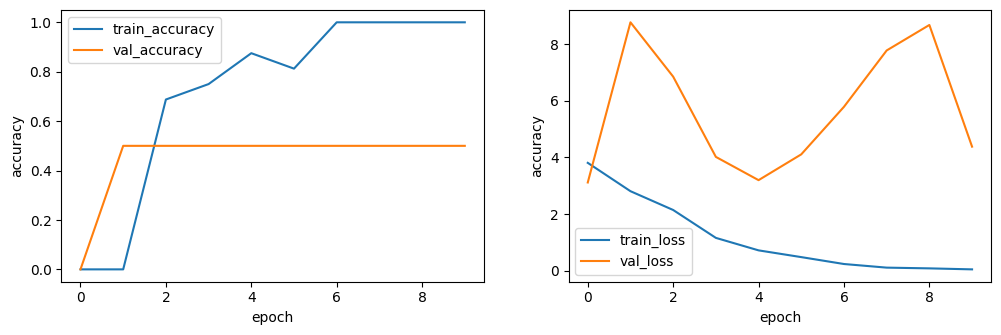

In [47]:
model = models.Sequential()
model.add(VGG19(weights=None, include_top=False, input_shape=(32,32,3)))
model.add(layers.BatchNormalization())
model.add(layers.Flatten())
model.add(layers.Dense(1024, activation='sigmoid'))
model.add(layers.Dense(43, activation='softmax'))

results(model)

In [48]:
print(df["ClassId"].dtype)
# Assuming 'df' is your DataFrame
df["ClassId"] = df["ClassId"].astype('int64')
df["ClassId"] = df["ClassId"].astype('str')
print(df["ClassId"].dtype)

object
object


In [49]:
df_test=[[]]
df_test=pd.DataFrame(df_test)
for i in trainclasses:
    path = "./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+"/GT-"+i+".csv"
    df1 = pd.read_csv(path,sep=';')
    df1['Filename']="./Belgium_Datasets/BelgiumTSC_Testing/Testing/"+i+'/'+df1["Filename"]
    df_test=pd.concat([df_test,df1],ignore_index=True)

df_test['Rotate']=0
df_test["length"] = df_test["Roi.X2"]-df_test["Roi.X1"]
df_test["height"] = df_test["Roi.Y2"]-df_test["Roi.Y1"]
df_test=df_test.dropna()
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,107.0,108.0,9.0,9.0,98.0,99.0,0.0,0,89.0,90.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,94.0,98.0,8.0,8.0,86.0,89.0,0.0,0,78.0,81.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,100.0,106.0,8.0,9.0,91.0,96.0,0.0,0,83.0,87.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,57.0,61.0,5.0,5.0,51.0,55.0,0.0,0,46.0,50.0
5,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,59.0,62.0,5.0,5.0,53.0,56.0,0.0,0,48.0,51.0


Total Training Examples :  2534


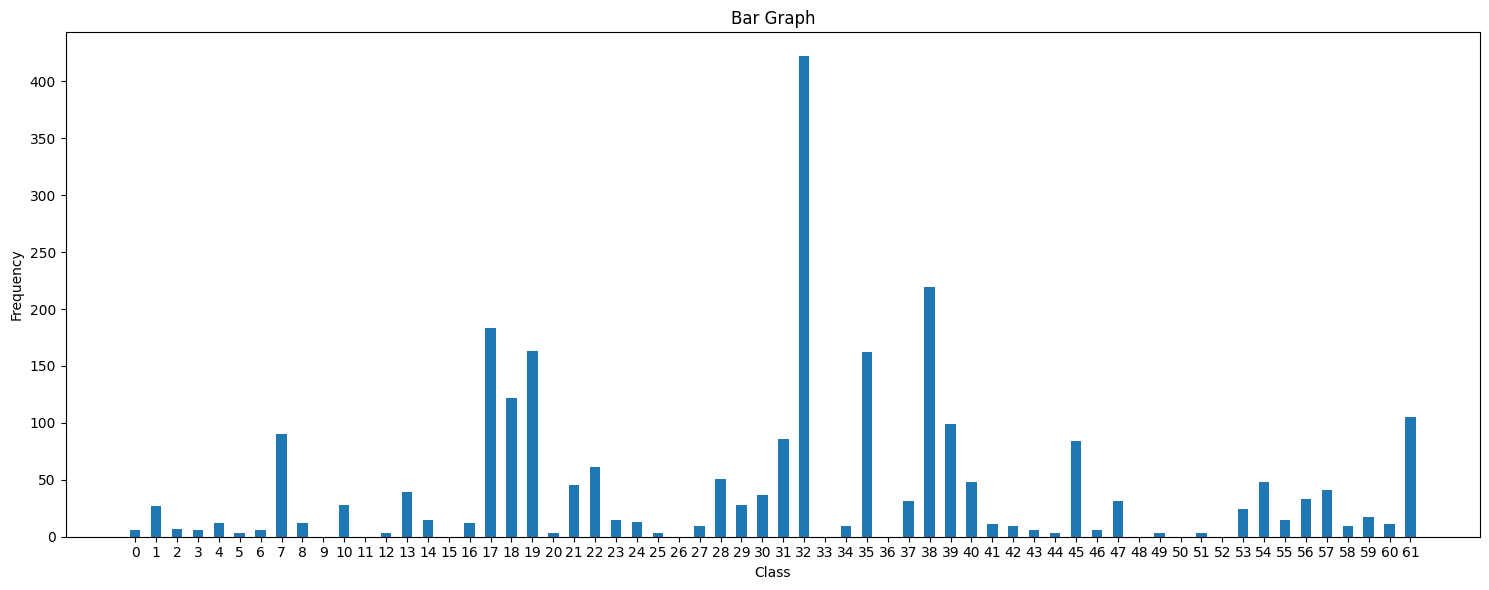

In [50]:
viewStatistics(df_test)

In [51]:
df_test.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Rotate,length,height
1,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,107.0,108.0,9.0,9.0,98.0,99.0,0.0,0,89.0,90.0
2,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,94.0,98.0,8.0,8.0,86.0,89.0,0.0,0,78.0,81.0
3,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,100.0,106.0,8.0,9.0,91.0,96.0,0.0,0,83.0,87.0
4,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,57.0,61.0,5.0,5.0,51.0,55.0,0.0,0,46.0,50.0
5,./Belgium_Datasets/BelgiumTSC_Testing/Testing/...,59.0,62.0,5.0,5.0,53.0,56.0,0.0,0,48.0,51.0


In [52]:
X = df_test.drop(Y_col_name, axis=1)
y = df_test[Y_col_name]
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)

# Fit and apply the oversampler to the data
X_resampled, y_resampled = oversampler.fit_resample(X, y)

df_test = pd.DataFrame(X_resampled, columns=X.columns)
df_test[Y_col_name] = y_resampled
df_test[Y_col_name] = df_test[Y_col_name].astype(str)

In [54]:
test_images,test_labels = load_test(df_test)
test_images = test_images.astype('float32') / 255.
test_labels = test_labels.astype('float32').astype('int')

In [55]:
pred = model.predict(test_images)
y_pred = np.argmax(pred, axis=1)

699/699 [==============================] - 70s 100ms/step


In [56]:
confusion = confusion_matrix(test_labels, y_pred)
# Calculate accuracy
accuracy = np.sum(np.diag(confusion)) / np.sum(confusion)
print("Total Accuracy: ", accuracy)

# Calculate precision, recall, and F1-score
classification_rep = classification_report(test_labels, y_pred, labels=np.unique([x for x in range(num_of_classes)]))

# Print the results
print("\nConfusion Matrix:\n", confusion)


lines = classification_rep.split('\n')
data = []

for line in lines[2:-5]:  # Exclude header and footer lines
    row_data = line.split()
    if len(row_data) > 0:
        class_name = row_data[0]
        precision = float(row_data[1])
        recall = float(row_data[2])
        f1_score = float(row_data[3])
        support = int(row_data[4])
        data.append([class_name, precision, recall, f1_score, support])

# Create a DataFrame
report = pd.DataFrame(data, columns=['Class', 'Precision', 'Recall', 'F1-Score', 'Support'])
# Print the DataFrame
print("\n\n\n Summarizing the results : ")
report

Total Accuracy:  0.018867924528301886

Confusion Matrix:
 [[422   0   0 ...   0   0   0]
 [422   0   0 ...   0   0   0]
 [422   0   0 ...   0   0   0]
 ...
 [422   0   0 ...   0   0   0]
 [422   0   0 ...   0   0   0]
 [422   0   0 ...   0   0   0]]



 Summarizing the results : 


C:\Users\vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vivek\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifie

,Class,Precision,Recall,F1-Score,Support
0,0,0.02,1.0,0.04,422
1,1,0.00,0.0,0.00,422
2,2,0.00,0.0,0.00,422
3,3,0.00,0.0,0.00,422
4,4,0.00,0.0,0.00,422
...,...,...,...,...,...
57,57,0.00,0.0,0.00,422
58,58,0.00,0.0,0.00,422
59,59,0.00,0.0,0.00,422
60,60,0.00,0.0,0.00,422


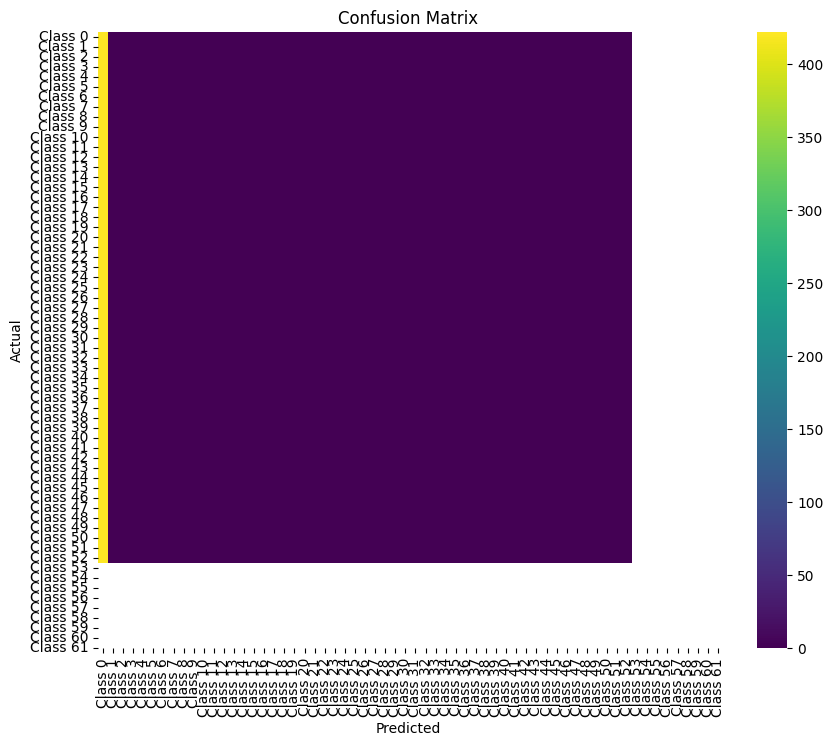

In [57]:
class_names = []
for i in range(num_of_classes):
    class_names.append("Class "+str(i))
# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=False, cmap="viridis", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()